In [628]:
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import numpy as np
import pandas as pd
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.utils import resample
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer

In [629]:
train_df = pd.read_json('../train.jsonl', lines=True)
X_train = train_df['string']
y_train = train_df['label']

test_df = pd.read_json('../test.jsonl', lines=True)

train_df

,source,citeEnd,sectionName,citeStart,string,label,label_confidence,citingPaperId,citedPaperId,isKeyCitation,id,unique_id,excerpt_index,label2,label2_confidence
0,explicit,175.0,Introduction,168.0,"However, how frataxin interacts with the Fe-S ...",background,1.0000,1872080baa7d30ec8fb87be9a65358cd3a7fb649,894be9b4ea46a5c422e81ef3c241072d4c73fdc0,True,1872080baa7d30ec8fb87be9a65358cd3a7fb649>894be...,1872080baa7d30ec8fb87be9a65358cd3a7fb649>894be...,11,NaN,NaN
1,explicit,36.0,Novel Quantitative Trait Loci for Seminal Root...,16.0,"In the study by Hickey et al. (2012), spikes w...",background,1.0000,ce1d09a4a3a8d7fd3405b9328f65f00c952cf64b,b6642e19efb8db5623b3cc4eef1c5822a6151107,True,ce1d09a4a3a8d7fd3405b9328f65f00c952cf64b>b6642...,ce1d09a4a3a8d7fd3405b9328f65f00c952cf64b>b6642...,2,NaN,NaN
2,explicit,228.0,Introduction,225.0,"The drug also reduces catecholamine secretion,...",background,1.0000,9cdf605beb1aa1078f235c4332b3024daa8b31dc,4e6a17fb8d7a3cada601d942e22eb5da6d01adbd,False,9cdf605beb1aa1078f235c4332b3024daa8b31dc>4e6a1...,9cdf605beb1aa1078f235c4332b3024daa8b31dc>4e6a1...,0,NaN,NaN
3,explicit,110.0,Discussion,46.0,By clustering with lowly aggressive close kin ...,background,1.0000,d9f3207db0c79a3b154f3875c9760cc6b056904b,2cc6ff899bf17666ad35893524a4d61624555ed7,False,d9f3207db0c79a3b154f3875c9760cc6b056904b>2cc6f...,d9f3207db0c79a3b154f3875c9760cc6b056904b>2cc6f...,3,NaN,NaN
4,explicit,239.0,Discussion,234.0,Ophthalmic symptoms are rare manifestations of...,background,1.0000,88b86556857f4374842d2af2e359576806239175,a5bb0ff1a026944d2a47a155462959af2b8505a8,False,88b86556857f4374842d2af2e359576806239175>a5bb0...,88b86556857f4374842d2af2e359576806239175>a5bb0...,2,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8238,explicit,50.0,,28.0,"Importantly, the results of Pascalis et al. (2...",background,0.7350,6f68ccd37718366c40ae6aeedf0b935bf560b215,60ed4bdabf92b2fbd6162dbd8979888cccca55d7,True,6f68ccd37718366c40ae6aeedf0b935bf560b215>60ed4...,6f68ccd37718366c40ae6aeedf0b935bf560b215>60ed4...,15,NaN,NaN
8239,explicit,182.0,DISCUSSION,179.0,"As suggested by Nguena et al, there is a need ...",background,0.7508,f2a1c1704f9587c94ed95bc98179dc499e933f5e,574e659da7f6c62c07bfaaacd1f31d65bd75524c,True,f2a1c1704f9587c94ed95bc98179dc499e933f5e>574e6...,f2a1c1704f9587c94ed95bc98179dc499e933f5e>574e6...,1,NaN,NaN
8240,explicit,120.0,DISCUSSION,108.0,Skeletal muscle is also a primary site of dise...,background,1.0000,18c97ea2ff60c110cc2a523e0fdf729608cbb083,fc13b9c3dfcc121013edaa12fa8ce7842aaed21a,False,18c97ea2ff60c110cc2a523e0fdf729608cbb083>fc13b...,18c97ea2ff60c110cc2a523e0fdf729608cbb083>fc13b...,8,NaN,NaN
8241,explicit,221.0,,185.0,ACTIVATION OF TRANSCRIPTION FACTORS Roles for ...,method,NaN,4ec9b89857c0b27e8a4bd3745b7358f387773527,81affdba19e38e2b17cf7b9e93792cc2028cf21d,True,4ec9b89857c0b27e8a4bd3745b7358f387773527>81aff...,4ec9b89857c0b27e8a4bd3745b7358f387773527>81aff...,0,NaN,NaN


In [630]:
def augment_data_multiclass(X, y):
    df = pd.concat([X, y], axis=1)
    majority_class_size = df['label'].value_counts().max()
    upsampled_dataframes = []
    for class_label in df['label'].unique():
        class_df = df[df['label'] == class_label]
        if len(class_df) < majority_class_size:
            class_df_upsampled = resample(class_df, replace=True, n_samples=majority_class_size, random_state=10)
            upsampled_dataframes.append(class_df_upsampled)
        else:
            upsampled_dataframes.append(class_df)
    upsampled_df = pd.concat(upsampled_dataframes)
    return upsampled_df['string'], upsampled_df['label']

In [631]:
X_train, y_train = augment_data_multiclass(X_train, y_train)

In [632]:
from sklearn.preprocessing import LabelEncoder

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform string column
y_train = label_encoder.fit_transform(y_train)

In [633]:
train_df = pd.DataFrame({
    'string': X_train,
    'label': y_train
})

<Axes: >

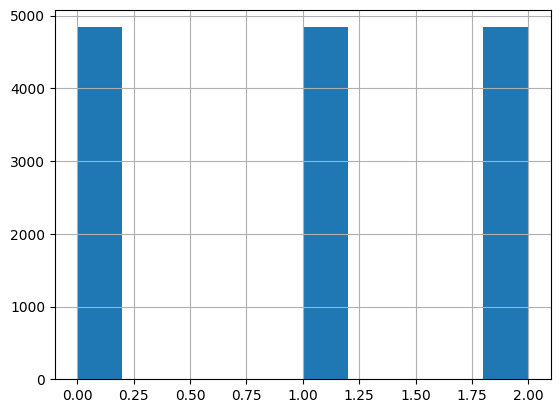

In [634]:
train_df.label.hist()

In [635]:
import re
import string
import nltk 

def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

#df_test['string_clean'] = df_test['string'].apply(clean_text)
#df_test.head()

stop_words = stopwords.words('english')
more_stopwords = ['u', 'im', 'c']
stop_words = stop_words + more_stopwords

def remove_stopwords(text):
    text = ' '.join(word for word in text.split(' ') if word not in stop_words)
    return text

stemmer = nltk.SnowballStemmer("english")

def stemm_text(text):
    text = ' '.join(stemmer.stem(word) for word in text.split(' '))
    return text

def preprocess_data(text):
    # Clean puntuation, urls, and so on
    text = clean_text(text)
    # Remove stopwords
    text = ' '.join(word for word in text.split(' ') if word not in stop_words)
    # Stemm all the words in the sentence
    text = ' '.join(stemmer.stem(word) for word in text.split(' '))

    return text




In [636]:
train_df['string'] = train_df['string'].apply(preprocess_data)

In [637]:
train_df.head()

,string,label
0,howev frataxin interact fes cluster biosynthes...,0
1,studi hickey et al spike sampl field point ph...,0
2,drug also reduc catecholamin secret therebi re...,0
3,cluster lowli aggress close kin king viblanc ...,0
4,ophthalm symptom rare manifest intracrani arac...,0


In [638]:
from torchtext.vocab import build_vocab_from_iterator
from torchtext.data.utils import get_tokenizer

tokenizer = get_tokenizer("basic_english")
tokens = [tokenizer(text.lower()) for text in train_df.string]

vocab = build_vocab_from_iterator(tokens)

NUM_VOCAB = len(vocab)

In [639]:
embeddings_dictionary = dict()
EMBEDDING_DIM = 100

# Load GloVe 100D embeddings
with open('glove.6B.100d.txt') as fp:
    for line in fp.readlines():
        records = line.split()
        word = records[0]
        vector_dimensions = np.asarray(records[1:], dtype='float32')
        embeddings_dictionary [word] = vector_dimensions

In [640]:
embedding_matrix = np.zeros((NUM_VOCAB, EMBEDDING_DIM))

for idx, word in enumerate(vocab.get_itos()):
    # Retrieve the embedding vector for the current word
    embedding_vector = embeddings_dictionary.get(word)

    # Check if the embedding vector exists
    if embedding_vector is not None:
        # Assign the embedding vector to the corresponding index in the matrix
        embedding_matrix[idx] = embedding_vector

for i in range(NUM_VOCAB):
    if np.all(embedding_matrix[i] == 0):
        # Assigning a random vector from a normal distribution
        embedding_matrix[i] = np.random.normal(scale=0.6, size=(EMBEDDING_DIM,))

embedding_matrix

array([[-0.044606  , -0.61925   , -1.14530003, ..., -1.36409998,
         0.35633001, -0.47716001],
       [-0.41431999, -0.46675   , -0.91295999, ..., -0.84961998,
         0.62581003, -0.63766998],
       [-0.087511  ,  0.14542   ,  0.29126999, ..., -0.095098  ,
         0.36195999, -0.53465003],
       ...,
       [-0.02694912,  0.22303687,  0.34876726, ...,  0.09159485,
        -0.1396103 ,  0.61024855],
       [-0.55432824, -0.10932295,  1.19728989, ..., -0.34358105,
         0.26565352, -0.12985906],
       [-0.61059607,  0.10722471,  0.52441386, ...,  0.41860791,
         0.43391994,  0.93387489]])

In [641]:
import torch 
import torch.nn as nn 

class LSTMWithGloveClassifier(nn.Module):
    def __init__(self, hidden_dim, output_dim):
        super().__init__()
        self.embedding = nn.Embedding(NUM_VOCAB, EMBEDDING_DIM)
        self.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix))
        self.lstm = nn.LSTM(EMBEDDING_DIM, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.embedding(x)
        lstm_out, _ = self.lstm(x)
        out = self.linear(lstm_out[:, -1, :])
        return torch.sigmoid(out)

In [642]:
tokenized_train_texts = [tokenizer(text.lower()) for text in train_df.string]

indexed_train_texts = [[vocab[token] for token in tokens if token in vocab] for tokens in tokenized_train_texts]



<Axes: >

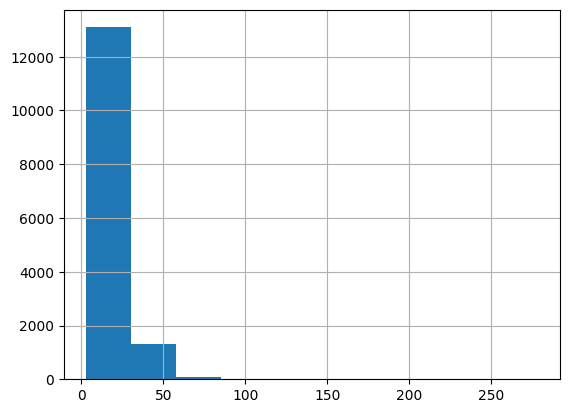

In [643]:
train_length = [len(i) for i in indexed_train_texts]
train_s = pd.Series(train_length)
train_s.hist()

In [644]:
SEQ_LEN = 100

padded_train_texts = [[0] * (SEQ_LEN - len(indexes)) + indexes  if len(indexes) <= SEQ_LEN else indexes[:SEQ_LEN] for indexes in indexed_train_texts]
X_train = torch.Tensor(padded_train_texts).to(int)
y_train = torch.LongTensor(y_train)


In [645]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.metrics import f1_score, accuracy_score

def eval_model(model, X_test, y_test):
    X_test = X_test.apply(preprocess_data)
    y_test = label_encoder.transform(y_test)
    
    tokenized_test_texts = [tokenizer(text.lower()) for text in X_test]
    indexed_test_texts = [[vocab[token] for token in tokens if token in vocab] for tokens in tokenized_test_texts]
    padded_test_texts = [[0] * (SEQ_LEN - len(indexes)) + indexes if len(indexes) <= SEQ_LEN else indexes[:SEQ_LEN] for indexes in indexed_test_texts]

    X_test = torch.Tensor(padded_test_texts).to(int)
    y_test = torch.LongTensor(y_test)

    dataset_test = TensorDataset(X_test, y_test)
    dataloader_test = DataLoader(dataset_test, sampler=SequentialSampler(dataset_test), batch_size=32)

    model.eval()
    predictions = []
    labels = []
    with torch.no_grad():
        for test_batch in dataloader_test:
            seq, label = test_batch

            out = model(seq)
            _, prediction  = torch.max(out, dim=1)

            predictions.extend(prediction.tolist())
            labels.extend(label.tolist())

    f1 = f1_score(labels, predictions, average='macro')
    acc = accuracy_score(labels, predictions)

    return f1, acc

In [646]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

dataset_train = TensorDataset(X_train, y_train)
dataloader_train = DataLoader(dataset_train, sampler=RandomSampler(dataset_train), batch_size=32)

In [647]:
from torch.optim import Adam 

model = LSTMWithGloveClassifier(50, 3)
optimizer = Adam(model.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()

for epoch in range(10):
    model.train()

    curr_total_loss = 0.
    count = 0

    for train_batch in dataloader_train:
        optimizer.zero_grad()

        seq, label = train_batch
        out = model(seq)
        
        loss = loss_fn(out, label)

        curr_total_loss += loss.item()
        count += 1

        loss.backward()
        optimizer.step()

    avg_loss = curr_total_loss / count 

    print(epoch, avg_loss)

0 0.8918584579938309
1 0.7261530600717939
2 0.6689505192414255
3 0.6403946166259077
4 0.6112941126728898
5 0.6021029119449565
6 0.5939952347772237
7 0.5899880758203598
8 0.5878380668320845
9 0.5947462396474662


### Default test data

In [648]:
X_test = test_df['string']
y_test = test_df['label']

eval_model(model, X_test, y_test)

(0.7080908669796143, 0.737775389575497)

### Short data

In [649]:
short_df = test_df[test_df['string'].apply(lambda x: len(nltk.word_tokenize(x)) <= 25)]
X_test_short = short_df['string']
y_test_short = short_df['label']

eval_model(model, X_test_short, y_test_short)

(0.7331932298375251, 0.7633587786259542)

### Long data

In [650]:
long_df = test_df[test_df['string'].apply(lambda x: len(nltk.word_tokenize(x)) > 25)]

X_test_long = long_df['string']
y_test_long = long_df['label']

eval_model(model, X_test_long, y_test_long)

(0.7043028709541711, 0.7335834896810507)

### Paragraph data

In [651]:
paragraph_df = test_df[test_df['string'].apply(lambda x: len(nltk.sent_tokenize(x)) > 1)]
X_test_paragraph = paragraph_df['string']
y_test_paragraph = paragraph_df['label']

eval_model(model, X_test_paragraph, y_test_paragraph)

(0.7244923903962804, 0.7481840193704601)

### Typo data

In [652]:
def rearrange_letter(word):
    word_list = list(word)
    n = len(word_list)
    if n == 1:
        return ''.join(word_list)

    idx = random.randint(0, n - 2)
    word_list[idx], word_list[idx + 1] = word_list[idx + 1], word_list[idx]
    return ''.join(word_list)

def rearrange_word(text):
    words = nltk.word_tokenize(text)
    num_words = len(words)

    # rearrange letter for some random word
    for _ in range(5):
        idx = random.randint(0, num_words - 1)
        words[idx] = rearrange_letter(words[idx])

    # rearrange word
    for _ in range(min(3, num_words - 1)):
        idx = random.randint(0, num_words - 2)
        words[idx], words[idx + 1] = words[idx + 1], words[idx]

    return ' '.join(words)

typo_series = test_df['string'].apply(rearrange_word)

typo_df = pd.DataFrame({
    'label': test_df.label,
    'string': typo_series
})

X_test_typo = typo_df['string']
y_test_typo = typo_df['label']

eval_model(model, X_test_typo, y_test_typo)

(0.6756503592063389, 0.7135948414830736)

### Synonymed data

In [653]:
synonymized_test_df = pd.read_json('../synonymized.jsonl', lines=True)

X_test_synonymed = synonymized_test_df['string']
y_test_synonymed = synonymized_test_df['label']

eval_model(model, X_test_synonymed, y_test_synonymed)

(0.5679314293001464, 0.6609349811929071)

### Paraphrased data

In [654]:
paraphrased_test_df = pd.read_json('../paraphrased.jsonl', lines=True)

X_test_paraphrased = paraphrased_test_df['string']
y_test_paraphrased = paraphrased_test_df['label']

eval_model(model, X_test_paraphrased, y_test_paraphrased)

(0.6746244713586087, 0.7049973132724342)